# 5-Class IoT Malware Classification with Two Neural Network Architectures

This notebook implements **5-class classification** training for IoT malware detection using reduced feature sets with two different neural network architectures:
1. **NeuralNetwork**: A simple 3-layer network
2. **NeuralNetwork1**: A deeper 5-layer network with dropout

## Dataset Information
- **Features**: 17 selected features from the original dataset
- **Classes**: 5 classes (Labels 0, 1, 2, 3, 4)
  - **0**: Benign
  - **1**: gafgyt.combo
  - **2**: gafgyt.junk
  - **3**: gafgyt.tcp
  - **4**: gafgyt.udp
- **Data Source**: `ReducedData/device_1_reduced.csv`

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Libraries imported successfully!
PyTorch version: 2.2.1+cpu
CUDA available: False
Using device: cpu


In [2]:
# Neural Network Architecture 1: Simple 3-layer network for Binary Classification
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes=5):  # Binary classification: 2 classes
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64) 
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

# Neural Network Architecture 2: Deeper network with dropout for Binary Classification
class NeuralNetwork1(nn.Module):
    def __init__(self, input_size, num_classes=5):  # Binary classification: 2 classes
        super(NeuralNetwork1, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x

print("Neural network architectures defined for binary classification!")
print(f"Architecture 1: NeuralNetwork (3 layers, 2 output classes)")
print(f"Architecture 2: NeuralNetwork1 (5 layers with dropout, 2 output classes)")

Neural network architectures defined for binary classification!
Architecture 1: NeuralNetwork (3 layers, 2 output classes)
Architecture 2: NeuralNetwork1 (5 layers with dropout, 2 output classes)


In [10]:
# Data Loading and Exploration with 5-Class Classification
print("Loading reduced dataset...")
data_path = ["ReducedData/device_1_reduced.csv","ReducedData/device_2_reduced.csv","ReducedData/device_6_reduced.csv","ReducedData/device_4_reduced.csv","ReducedData/device_7_reduced.csv","ReducedData/device_5_reduced.csv"]
dfs = []

for i in data_path:
    dfs.append(pd.read_csv(i))

# Concatenate all DataFrames into one
df = pd.concat(dfs, ignore_index=True)

print(f"Original dataset shape: {df.shape}")
print(f"Features: {df.shape[1] - 1}")  # Excluding label column
print(f"Samples: {df.shape[0]}")

# Display original label distribution
print("\nOriginal label distribution:")
original_label_counts = df['label'].value_counts().sort_index()
print(original_label_counts)

# Filter for only labels 0, 1, 2, 3, 4 (5-class classification)
print("\n" + "="*50)
print("FILTERING FOR 5-CLASS CLASSIFICATION")
print("="*50)
print("Keeping only labels 0, 1, 2, 3, 4")
print("Removing labels 5-9 (mirai variants)")

# Keep only rows with labels 0, 1, 2, 3, 4
df_filtered = df[df['label'].isin([0, 1, 2,3,5,6,7,8,9])].copy()

print(f"\nOriginal dataset samples: {len(df)}")
print(f"Filtered dataset samples: {len(df_filtered)}")
print(f"Removed samples: {len(df) - len(df_filtered)}")

# Display filtered label distribution
print("\nFiltered label distribution (5 classes):")
filtered_label_counts = df_filtered['label'].value_counts().sort_index()
print(filtered_label_counts)

# Label mapping for 5-class classification
class_label_mapping = {
    0: 'Benign',
    1: 'gafgyt.combo',
    2: 'gafgyt.junk', 
    3: 'gafgyt.tcp',
    4: 'gafgyt.udp',
    5: 'mirai.ack',
    6: 'mirai.scan',
    7: 'mirai.sin',
    8: 'mirai.udp',
    9:'mirai.udpplain'
}

print("\n5-Class label mapping:")
for label, name in class_label_mapping.items():
    count = filtered_label_counts.get(label, 0)
    percentage = (count / len(df_filtered)) * 100
    print(f"{label}: {name} ({count} samples, {percentage:.1f}%)")

# Update dataframe for further processing
df = df_filtered

print(f"\nDataset shape after filtering: {df.shape}")
print("Dataset ready for 5-class classification!")

Loading reduced dataset...
Original dataset shape: (660000, 18)
Features: 17
Samples: 660000

Original label distribution:
label
0    72000
1    72000
2    72000
3    72000
4    72000
5    60000
6    60000
7    60000
8    60000
9    60000
Name: count, dtype: int64

FILTERING FOR 5-CLASS CLASSIFICATION
Keeping only labels 0, 1, 2, 3, 4
Removing labels 5-9 (mirai variants)

Original dataset samples: 660000
Filtered dataset samples: 588000
Removed samples: 72000

Filtered label distribution (5 classes):
label
0    72000
1    72000
2    72000
3    72000
5    60000
6    60000
7    60000
8    60000
9    60000
Name: count, dtype: int64

5-Class label mapping:
0: Benign (72000 samples, 12.2%)
1: gafgyt.combo (72000 samples, 12.2%)
2: gafgyt.junk (72000 samples, 12.2%)
3: gafgyt.tcp (72000 samples, 12.2%)
4: gafgyt.udp (0 samples, 0.0%)
5: mirai.ack (60000 samples, 10.2%)
6: mirai.scan (60000 samples, 10.2%)
7: mirai.sin (60000 samples, 10.2%)
8: mirai.udp (60000 samples, 10.2%)
9: mirai.udppla

In [12]:
# Data Preprocessing and Preparation
print("Preparing data for training...")

# Separate features and labels
feature_columns = [col for col in df.columns if col != 'label']
X = df[feature_columns].values
y = df['label'].values

print(f"Feature shape: {X.shape}")
print(f"Label shape: {y.shape}")
print(f"Number of classes: {len(np.unique(y))}")

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Further split training data to create validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Final training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("\nData standardization completed!")
print(f"Feature mean (after scaling): {X_train_scaled.mean():.6f}")
print(f"Feature std (after scaling): {X_train_scaled.std():.6f}")

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
X_val_tensor = torch.FloatTensor(X_val_scaled)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_train_tensor = torch.LongTensor(y_train)
y_val_tensor = torch.LongTensor(y_val)
y_test_tensor = torch.LongTensor(y_test)

print("Data converted to PyTorch tensors successfully!")

Preparing data for training...
Feature shape: (588000, 17)
Label shape: (588000,)
Number of classes: 9
Training set: 470400 samples
Test set: 117600 samples
Final training set: 376320 samples
Validation set: 94080 samples
Test set: 117600 samples

Data standardization completed!
Feature mean (after scaling): 0.000000
Feature std (after scaling): 1.000000
Data converted to PyTorch tensors successfully!


In [13]:
# Create DataLoaders for efficient batch processing - Binary Classification
batch_size = 128

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"DataLoaders created successfully for binary classification!")
print(f"Batch size: {batch_size}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

# Get input size and number of classes for model initialization
input_size = X_train.shape[1]
num_classes = 10 # Binary classification: Benign vs Attack

print(f"\nModel parameters for binary classification:")
print(f"Input size: {input_size}")
print(f"Number of classes: {num_classes} (Benign vs Attack)")

DataLoaders created successfully for binary classification!
Batch size: 128
Training batches: 2940
Validation batches: 735
Test batches: 919

Model parameters for binary classification:
Input size: 17
Number of classes: 10 (Benign vs Attack)


In [14]:
# Simple Training and Evaluation Functions for Binary Classification
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=15, device='cpu'):
    """
    Simple training function for binary classification
    """
    model.to(device)
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    print(f"Starting simple training for {num_epochs} epochs (Binary Classification)...")
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(output, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                
                val_loss += loss.item()
                _, predicted = torch.max(output, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()
        
        # Calculate averages
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_acc = 100. * train_correct / train_total
        val_acc = 100. * val_correct / val_total
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        # Print results
        print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }

def evaluate_model(model, test_loader, device='cpu'):
    """
    Simple evaluation function for binary classification
    """
    model.eval()
    test_correct = 0
    test_total = 0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            
            test_total += target.size(0)
            test_correct += (predicted == target).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    test_acc = 100. * test_correct / test_total
    print(f'Test Accuracy: {test_acc:.2f}%')
    
    return test_acc, all_predictions, all_targets

print("Simple training and evaluation functions defined for binary classification!")

Simple training and evaluation functions defined for binary classification!


In [15]:
# Training Neural Network 1 (Simple 3-layer network) - 5-Class Classification
print("="*60)
print("TRAINING NEURAL NETWORK 1 (Simple 3-layer) - 5-CLASS CLASSIFICATION")
print("="*60)

# Initialize the first model
model1 = NeuralNetwork(input_size, num_classes)
print(f"Model 1 Architecture for 5-Class Classification:")
print(model1)

# Count parameters
total_params = sum(p.numel() for p in model1.parameters())
trainable_params = sum(p.numel() for p in model1.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Define loss function and optimizer for model 1
criterion1 = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)

# Train model 1 for 15 epochs
history1 = train_model(
    model=model1,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion1,
    optimizer=optimizer1,
    num_epochs=10,
    device=device
)

print(f"\nTraining completed for Neural Network 1!")
print(f"Final validation accuracy: {history1['val_accuracies'][-1]:.2f}%")

TRAINING NEURAL NETWORK 1 (Simple 3-layer) - 5-CLASS CLASSIFICATION
Model 1 Architecture for 5-Class Classification:
NeuralNetwork(
  (fc1): Linear(in_features=17, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

Total parameters: 11,210
Trainable parameters: 11,210
Starting simple training for 10 epochs (Binary Classification)...
Epoch 1/10: Train Loss: 0.2883, Train Acc: 88.33%, Val Loss: 0.1206, Val Acc: 96.14%
Epoch 2/10: Train Loss: 0.0773, Train Acc: 97.69%, Val Loss: 0.0483, Val Acc: 98.58%
Epoch 3/10: Train Loss: 0.0419, Train Acc: 98.69%, Val Loss: 0.0323, Val Acc: 99.08%
Epoch 4/10: Train Loss: 0.0312, Train Acc: 98.97%, Val Loss: 0.0277, Val Acc: 99.08%
Epoch 5/10: Train Loss: 0.0256, Train Acc: 99.11%, Val Loss: 0.0232, Val Acc: 99.13%
Epoch 6/10: Train Loss: 0.0222, Train Acc: 99.25%, Val Loss: 0.0197, Val Acc: 99.18%
Epoch 7/10: Train Loss: 0.0190, Trai

KeyboardInterrupt: 

In [54]:
# Training Neural Network 2 (Deeper 5-layer network with dropout)
print("="*60)
print("TRAINING NEURAL NETWORK 2 (Deeper 5-layer with dropout)")
print("="*60)

# Initialize the second model
model2 = NeuralNetwork1(input_size, num_classes)
print(f"Model 2 Architecture:")
print(model2)

# Count parameters
total_params = sum(p.numel() for p in model2.parameters())
trainable_params = sum(p.numel() for p in model2.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Define loss function and optimizer for model 2
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)

# Train model 2 for 15 epochs
history2 = train_model(
    model=model2,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion2,
    optimizer=optimizer2,
    num_epochs=15,
    device=device
)

print(f"\nTraining completed for Neural Network 2!")
print(f"Final validation accuracy: {history2['val_accuracies'][-1]:.2f}%")

TRAINING NEURAL NETWORK 2 (Deeper 5-layer with dropout)
Model 2 Architecture:
NeuralNetwork1(
  (fc1): Linear(in_features=17, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=3, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)

Total parameters: 47,939
Trainable parameters: 47,939
Starting simple training for 15 epochs (Binary Classification)...
Epoch 1/15: Train Loss: 0.4000, Train Acc: 83.49%, Val Loss: 0.2328, Val Acc: 90.43%
Epoch 2/15: Train Loss: 0.2079, Train Acc: 91.05%, Val Loss: 0.1523, Val Acc: 93.12%
Epoch 3/15: Train Loss: 0.1531, Train Acc: 93.26%, Val Loss: 0.1444, Val Acc: 93.23%
Epoch 4/15: Train Loss: 0.1300, Train Acc: 94.06%, Val Loss: 0.1139, Val Acc: 94.08%
Epoch 5/15: Train Loss: 0.1201, Train Acc: 94.26%, Val Loss: 0.1043, Val Acc: 94

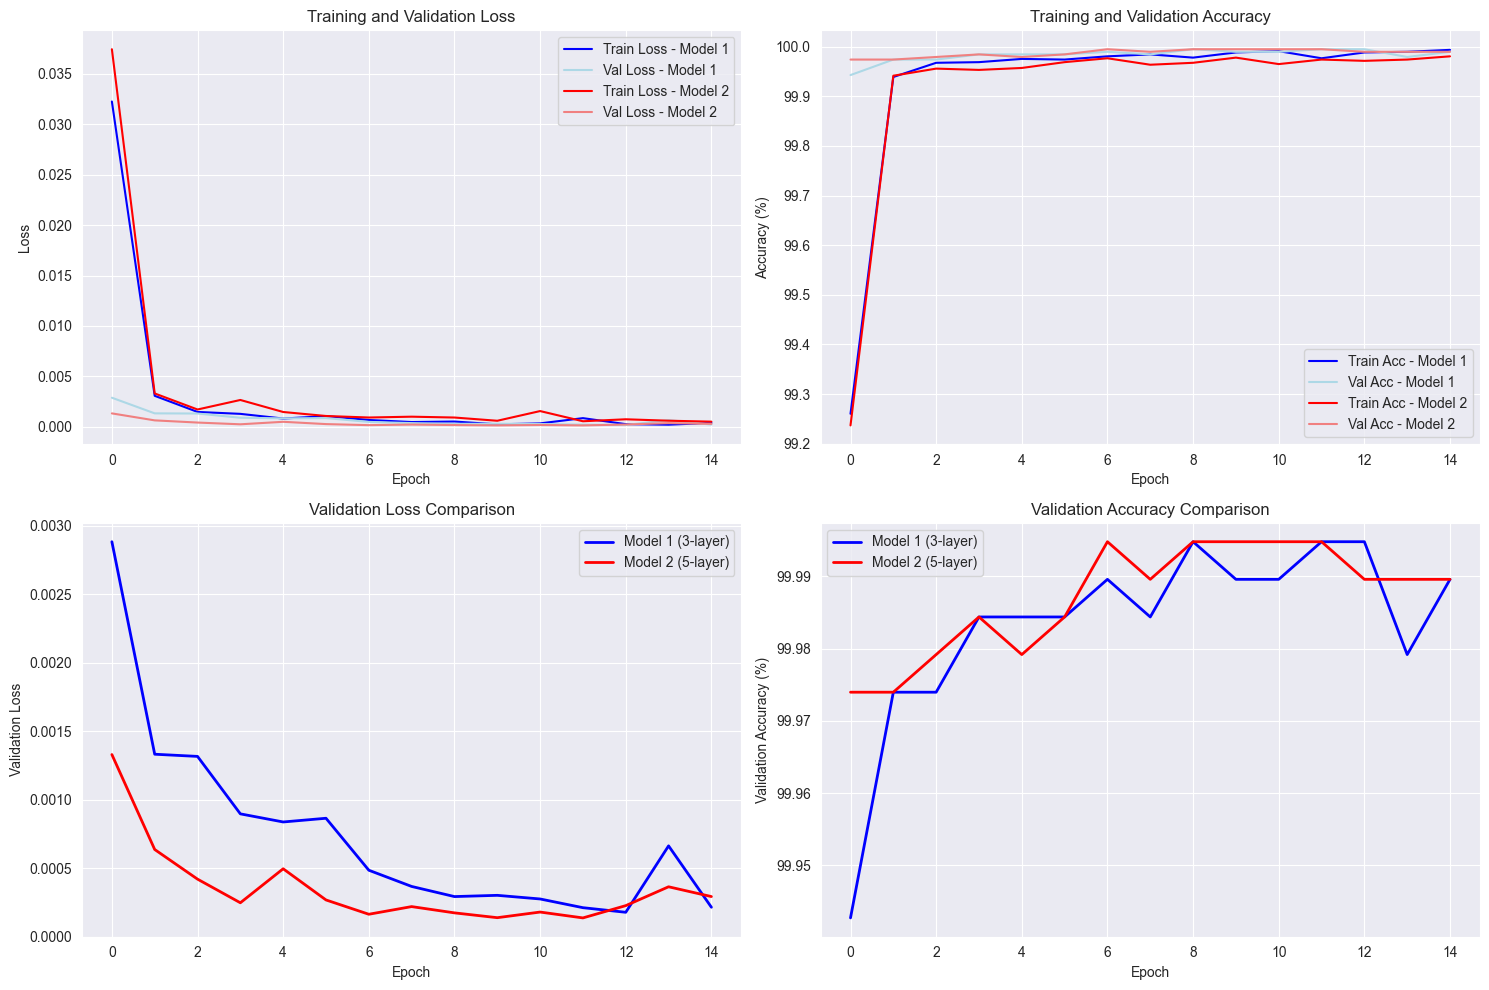

TRAINING SUMMARY COMPARISON
Model 1 (3-layer) - Final Validation Accuracy: 99.99%
Model 2 (5-layer) - Final Validation Accuracy: 99.99%
Difference: 0.00%
Model 1 (simpler network) performs better!


In [36]:
# Visualize Training History
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot training and validation loss for both models
axes[0, 0].plot(history1['train_losses'], label='Train Loss - Model 1', color='blue')
axes[0, 0].plot(history1['val_losses'], label='Val Loss - Model 1', color='lightblue')
axes[0, 0].plot(history2['train_losses'], label='Train Loss - Model 2', color='red')
axes[0, 0].plot(history2['val_losses'], label='Val Loss - Model 2', color='lightcoral')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot training and validation accuracy for both models
axes[0, 1].plot(history1['train_accuracies'], label='Train Acc - Model 1', color='blue')
axes[0, 1].plot(history1['val_accuracies'], label='Val Acc - Model 1', color='lightblue')
axes[0, 1].plot(history2['train_accuracies'], label='Train Acc - Model 2', color='red')
axes[0, 1].plot(history2['val_accuracies'], label='Val Acc - Model 2', color='lightcoral')
axes[0, 1].set_title('Training and Validation Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot loss comparison
axes[1, 0].plot(history1['val_losses'], label='Model 1 (3-layer)', color='blue', linewidth=2)
axes[1, 0].plot(history2['val_losses'], label='Model 2 (5-layer)', color='red', linewidth=2)
axes[1, 0].set_title('Validation Loss Comparison')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Validation Loss')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot accuracy comparison
axes[1, 1].plot(history1['val_accuracies'], label='Model 1 (3-layer)', color='blue', linewidth=2)
axes[1, 1].plot(history2['val_accuracies'], label='Model 2 (5-layer)', color='red', linewidth=2)
axes[1, 1].set_title('Validation Accuracy Comparison')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Validation Accuracy (%)')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Print comparison summary
print("="*60)
print("TRAINING SUMMARY COMPARISON")
print("="*60)
final_val_acc1 = history1['val_accuracies'][-1]
final_val_acc2 = history2['val_accuracies'][-1]
print(f"Model 1 (3-layer) - Final Validation Accuracy: {final_val_acc1:.2f}%")
print(f"Model 2 (5-layer) - Final Validation Accuracy: {final_val_acc2:.2f}%")
print(f"Difference: {abs(final_val_acc2 - final_val_acc1):.2f}%")

if final_val_acc2 > final_val_acc1:
    print("Model 2 (deeper network) performs better!")
else:
    print("Model 1 (simpler network) performs better!")

In [37]:
# Evaluate Both Models on Test Data - 5-Class Classification
print("="*60)
print("MODEL EVALUATION ON TEST DATA - 5-CLASS CLASSIFICATION")
print("="*60)

# Evaluate Model 1
print("Evaluating Model 1 (3-layer network)...")
test_acc1, predictions1, targets1 = evaluate_model(model1, test_loader, device)

print("\nEvaluating Model 2 (5-layer network)...")
test_acc2, predictions2, targets2 = evaluate_model(model2, test_loader, device)

# Print test results comparison
print("\n" + "="*60)
print("TEST RESULTS COMPARISON - 5-CLASS CLASSIFICATION")
print("="*60)
print(f"Model 1 (3-layer) Test Accuracy: {test_acc1:.2f}%")
print(f"Model 2 (5-layer) Test Accuracy: {test_acc2:.2f}%")
print(f"Difference: {abs(test_acc2 - test_acc1):.2f}%")

if test_acc2 > test_acc1:
    print("Model 2 (deeper network) performs better on test data!")
    better_model = model2
    better_predictions = predictions2
    better_name = "Model 2 (5-layer)"
else:
    print("Model 1 (simpler network) performs better on test data!")
    better_model = model1
    better_predictions = predictions1
    better_name = "Model 1 (3-layer)"

print(f"\nBest performing model: {better_name}")

# 5-class classification labels
class_labels = ['benign', 'gafgyt.combo', 'gafgyt.junk', 'gafgyt.tcp', 'gafgyt.udp']

# Detailed classification reports
print(f"\n{'-'*40}")
print("DETAILED CLASSIFICATION REPORT - MODEL 1")
print(f"{'-'*40}")
print(classification_report(targets1, predictions1, target_names=class_labels))

print(f"\n{'-'*40}")
print("DETAILED CLASSIFICATION REPORT - MODEL 2")
print(f"{'-'*40}")
print(classification_report(targets2, predictions2, target_names=class_labels))

MODEL EVALUATION ON TEST DATA - 5-CLASS CLASSIFICATION
Evaluating Model 1 (3-layer network)...
Test Accuracy: 99.98%

Evaluating Model 2 (5-layer network)...
Test Accuracy: 99.97%

TEST RESULTS COMPARISON - 5-CLASS CLASSIFICATION
Model 1 (3-layer) Test Accuracy: 99.98%
Model 2 (5-layer) Test Accuracy: 99.97%
Difference: 0.00%
Model 1 (simpler network) performs better on test data!

Best performing model: Model 1 (3-layer)

----------------------------------------
DETAILED CLASSIFICATION REPORT - MODEL 1
----------------------------------------


ValueError: Number of classes, 2, does not match size of target_names, 5. Try specifying the labels parameter

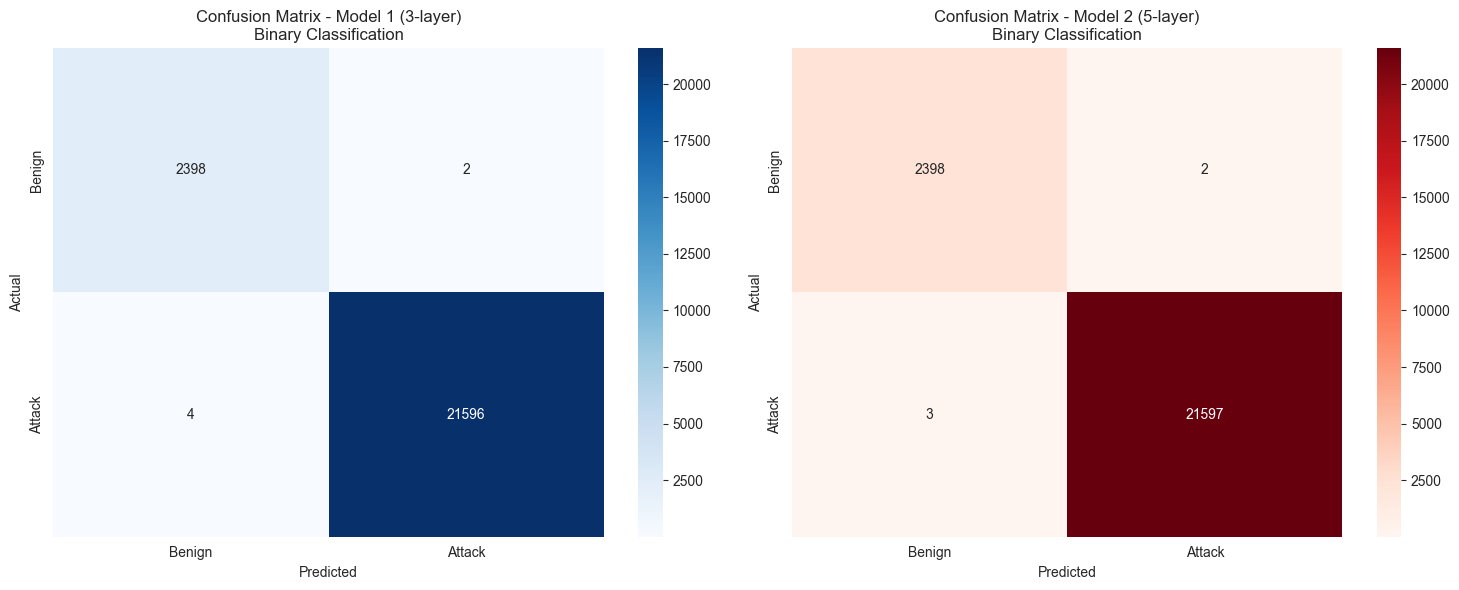


PER-CLASS ACCURACY COMPARISON - BINARY CLASSIFICATION
Class        Model 1      Model 2      Difference  
--------------------------------------------------
Benign       99.92        99.92        0.00        
Attack       99.98        99.99        0.00        
--------------------------------------------------
Overall      99.97        99.98        0.00        

----------------------------------------
ADDITIONAL METRICS - BINARY CLASSIFICATION
----------------------------------------

Model 1:
  Precision: 0.9999
  Recall: 0.9998
  F1-Score: 0.9999

Model 2:
  Precision: 0.9999
  Recall: 0.9999
  F1-Score: 0.9999


In [ ]:
# Confusion Matrices - 5-Class Classification
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 5-class classification labels
class_labels = ['benign', 'gafgyt.combo', 'gafgyt.junk', 'gafgyt.tcp', 'gafgyt.udp']

# Confusion matrix for Model 1
cm1 = confusion_matrix(targets1, predictions1)
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix - Model 1 (3-layer)\n5-Class Classification')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_xticklabels(class_labels, rotation=45)
axes[0].set_yticklabels(class_labels, rotation=0)

# Confusion matrix for Model 2
cm2 = confusion_matrix(targets2, predictions2)
sns.heatmap(cm2, annot=True, fmt='d', cmap='Reds', ax=axes[1])
axes[1].set_title('Confusion Matrix - Model 2 (5-layer)\n5-Class Classification')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_xticklabels(class_labels, rotation=45)
axes[1].set_yticklabels(class_labels, rotation=0)

plt.tight_layout()
plt.show()

# Calculate per-class accuracy for both models (5-class)
def calculate_per_class_accuracy(targets, predictions, num_classes):
    per_class_acc = {}
    for class_idx in range(num_classes):
        class_mask = np.array(targets) == class_idx
        if class_mask.sum() > 0:
            class_predictions = np.array(predictions)[class_mask]
            class_targets = np.array(targets)[class_mask]
            accuracy = (class_predictions == class_targets).mean() * 100
            per_class_acc[class_idx] = accuracy
        else:
            per_class_acc[class_idx] = 0.0
    return per_class_acc

# Per-class accuracy for 5-class classification
per_class_acc1 = calculate_per_class_accuracy(targets1, predictions1, 5)
per_class_acc2 = calculate_per_class_accuracy(targets2, predictions2, 5)

print("\n" + "="*70)
print("PER-CLASS ACCURACY COMPARISON - 5-CLASS CLASSIFICATION")
print("="*70)
print(f"{'Class':<15} {'Model 1':<12} {'Model 2':<12} {'Difference':<12}")
print("-" * 70)

for class_idx in range(5):
    class_name = class_labels[class_idx]
    acc1 = per_class_acc1[class_idx]
    acc2 = per_class_acc2[class_idx]
    diff = acc2 - acc1
    print(f"{class_name:<15} {acc1:<12.2f} {acc2:<12.2f} {diff:<12.2f}")

print("-" * 70)
print(f"{'Overall':<15} {test_acc1:<12.2f} {test_acc2:<12.2f} {test_acc2-test_acc1:<12.2f}")

# Additional metrics for 5-class classification
from sklearn.metrics import precision_score, recall_score, f1_score

print(f"\n{'-'*50}")
print("ADDITIONAL METRICS - 5-CLASS CLASSIFICATION")
print(f"{'-'*50}")

for model_idx, (predictions, targets, model_name) in enumerate([(predictions1, targets1, "Model 1"), 
                                                                (predictions2, targets2, "Model 2")]):
    # Use weighted average for multi-class metrics
    precision = precision_score(targets, predictions, average='weighted')
    recall = recall_score(targets, predictions, average='weighted')
    f1 = f1_score(targets, predictions, average='weighted')
    
    print(f"\n{model_name} (Weighted Average):")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")

In [ ]:
# Save Trained Models - Binary Classification
import os

# Create directory for saving models if it doesn't exist
save_dir = "SavedModels"
os.makedirs(save_dir, exist_ok=True)

# Save Model 1
model1_path = os.path.join(save_dir, "binary_neural_network_3layer.pth")
torch.save({
    'model_state_dict': model1.state_dict(),
    'model_architecture': 'NeuralNetwork',
    'input_size': input_size,
    'num_classes': num_classes,  # 2 for binary classification
    'test_accuracy': test_acc1,
    'validation_accuracy': history1['val_accuracies'][-1],
    'scaler_mean': scaler.mean_,
    'scaler_scale': scaler.scale_,
    'classification_type': 'binary'
}, model1_path)

# Save Model 2
model2_path = os.path.join(save_dir, "binary_neural_network_5layer.pth")
torch.save({
    'model_state_dict': model2.state_dict(),
    'model_architecture': 'NeuralNetwork1',
    'input_size': input_size,
    'num_classes': num_classes,  # 2 for binary classification
    'test_accuracy': test_acc2,
    'validation_accuracy': history2['val_accuracies'][-1],
    'scaler_mean': scaler.mean_,
    'scaler_scale': scaler.scale_,
    'classification_type': 'binary'
}, model2_path)

print("Binary classification models saved successfully!")
print(f"Model 1 saved to: {model1_path}")
print(f"Model 2 saved to: {model2_path}")

# Save training results summary
results_summary = {
    'Model 1 (3-layer)': {
        'test_accuracy': test_acc1,
        'validation_accuracy': history1['val_accuracies'][-1],
        'parameters': sum(p.numel() for p in model1.parameters()),
        'architecture': 'Simple 3-layer network',
        'classification': 'Binary (Benign vs Attack)'
    },
    'Model 2 (5-layer)': {
        'test_accuracy': test_acc2,
        'validation_accuracy': history2['val_accuracies'][-1],
        'parameters': sum(p.numel() for p in model2.parameters()),
        'architecture': 'Deeper 5-layer network with dropout',
        'classification': 'Binary (Benign vs Attack)'
    }
}

# Print final summary
print("\n" + "="*60)
print("FINAL BINARY CLASSIFICATION TRAINING SUMMARY")
print("="*60)
for model_name, results in results_summary.items():
    print(f"\n{model_name}:")
    print(f"  Architecture: {results['architecture']}")
    print(f"  Classification: {results['classification']}")
    print(f"  Parameters: {results['parameters']:,}")
    print(f"  Validation Accuracy: {results['validation_accuracy']:.2f}%")
    print(f"  Test Accuracy: {results['test_accuracy']:.2f}%")

# Determine best model
if test_acc2 > test_acc1:
    best_model_name = "Model 2 (5-layer)"
    improvement = test_acc2 - test_acc1
else:
    best_model_name = "Model 1 (3-layer)"
    improvement = test_acc1 - test_acc2

print(f"\n🏆 Best performing model: {best_model_name}")
print(f"📈 Performance improvement: {improvement:.2f}%")
print(f"💾 Models saved in: {save_dir}/")
print(f"🎯 Classification type: Binary (Benign vs Attack)")
print("\nBinary classification training completed successfully! 🎉")